## 1: Install and Import libraries

In [1]:
!pip install gym

In [ ]:
!pip install hiplot

In [2]:
import random
import torch
import numpy as np
import gym
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torch import nn
from collections import deque,namedtuple

In [3]:
device = torch.device("cuda") if (torch.cuda.is_available()) else torch.device("cpu")
print(device)

cuda


In [4]:
!apt update
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:10 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [917 kB]
Get:12 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:13 http://ppa.lau

In [5]:
import glob
import io
import base64
import os
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import Monitor

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
import hiplot as hip
import plotly.express as px
import cv2

In [7]:
display = Display(visible=0, size=(1400, 900))
display.start()

In [8]:
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

## 2: Instantiate environment

In [9]:
import gym
env = gym.make('Acrobot-v1')
env.seed(0)

print(env.action_space)
print(env.observation_space)

Discrete(3)
Box(-28.274333953857422, 28.274333953857422, (6,), float32)


In [10]:
import gym
env = gym.make('Acrobot-v1') # Initialize the Gym environment
env.seed(0) # Set a random seed for the environment (reproducible results)

# Get the shapes of the state space (observation_space) and action space (action_space)
state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n

print(f"STATE SPACE SIZE: {state_space_dim}")
print(f"ACTION SPACE SIZE: {action_space_dim}")

STATE SPACE SIZE: 6
ACTION SPACE SIZE: 3


In [11]:
env.action_space

Discrete(3)

In [12]:
env.observation_space

Box(-28.274333953857422, 28.274333953857422, (6,), float32)

## 3: Random Agent

In [13]:
def show_videos():
  mp4list = glob.glob('video/*.mp4')
  mp4list.sort()
  for mp4 in mp4list:
    print(f"\nSHOWING VIDEO {mp4}")
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    
def wrap_env(env, video_callable=None):
  env = Monitor(env, './video', force=True, video_callable=video_callable)
  return env

In [14]:
env = gym.make('Acrobot-v1')
env.seed(0)
env = wrap_env(env, video_callable=lambda episode_id: True)

for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    score = 0
    done = False
    while not done and score > -500:
      # Choose a random action
      action = random.choice([0, 1, 2])
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment (optional, comment this line to speed up the simulation)
      env.render()
      # Update the final score (-1 for each step)
      score += reward 
      # Set the current state for the next iteration
      state = next_state
      # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 

EPISODE 1 - FINAL SCORE: -500.0
EPISODE 2 - FINAL SCORE: -500.0
EPISODE 3 - FINAL SCORE: -500.0
EPISODE 4 - FINAL SCORE: -500.0
EPISODE 5 - FINAL SCORE: -500.0
EPISODE 6 - FINAL SCORE: -500.0
EPISODE 7 - FINAL SCORE: -500.0
EPISODE 8 - FINAL SCORE: -500.0
EPISODE 9 - FINAL SCORE: -500.0
EPISODE 10 - FINAL SCORE: -500.0


In [ ]:
show_videos()


SHOWING VIDEO video/openaigym.video.0.74.video000000.mp4



SHOWING VIDEO video/openaigym.video.0.74.video000001.mp4

SHOWING VIDEO video/openaigym.video.0.74.video000002.mp4



SHOWING VIDEO video/openaigym.video.0.74.video000003.mp4



SHOWING VIDEO video/openaigym.video.0.74.video000004.mp4



SHOWING VIDEO video/openaigym.video.0.74.video000005.mp4



SHOWING VIDEO video/openaigym.video.0.74.video000006.mp4



SHOWING VIDEO video/openaigym.video.0.74.video000007.mp4



SHOWING VIDEO video/openaigym.video.0.74.video000008.mp4



SHOWING VIDEO video/openaigym.video.0.74.video000009.mp4


## 4: DQN

In [14]:
class ReplayMemory(object):

    def __init__(self, capacity):
        # Define a queue with maxlen "capacity"
        self.memory = deque(maxlen=capacity)

    def push(self, state, action, next_state, reward):
        # Add the tuple (state, action, next_state, reward) to the queue
        self.memory.append((state, action, next_state, reward))

    def sample(self, batch_size):
        batch_size = min(batch_size, len(self)) # Get all the samples if the requested batch_size is higher than the number of sample currently in the memory
        # Randomly select "batch_size" samples and return the selection
        return random.sample(self.memory,batch_size)

    def __len__(self):
        return len(self.memory) # Return the number of samples currently stored in the memory

In [15]:
class DQN(nn.Module):

    def __init__(self, state_space_dim, action_space_dim):
        super().__init__()

        self.linear = nn.Sequential(
                  nn.Linear(state_space_dim,64),
                  nn.ReLU(),
                  nn.Linear(64,64*2),
                  nn.ReLU(),
                  nn.Linear(64*2,action_space_dim)
                )

    def forward(self, x):
        x = x.to(device)
        return self.linear(x)

In [16]:
def choose_action_epsilon_greedy(net, state, epsilon):
    
    if epsilon > 1 or epsilon < 0:
        raise Exception('The epsilon value must be between 0 and 1')
                
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32) # Convert the state to tensor
        net_out = net(state)

    # Get the best action (argmax of the network output)
    best_action = int(net_out.argmax())
    # Get the number of possible actions
    action_space_dim = net_out.shape[-1]

    # Select a non optimal action with probability epsilon, otherwise choose the best action
    if random.random() < epsilon:
        # List of non-optimal actions (this list includes all the actions but the optimal one)
        non_optimal_actions = [a for a in range(action_space_dim) if a != best_action]
        # Select randomly from non_optimal_actions
        action = random.choice(non_optimal_actions)
    else:
        # Select best action
        action = best_action
        
    return action, net_out.cpu().numpy()

In [17]:
def choose_action_softmax(net, state, temperature):
    
    if temperature < 0:
        raise Exception('The temperature value must be greater than or equal to 0 ')
        
    # If the temperature is 0, just select the best action using the eps-greedy policy with epsilon = 0
    if temperature == 0:
        return choose_action_epsilon_greedy(net, state, 0)
    
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32)
        net_out = net(state)

    # Apply softmax with temp
    temperature = max(temperature, 1e-8) # set a minimum to the temperature for numerical stability
    softmax_out = nn.functional.softmax(net_out/temperature, dim=0).cpu().numpy()
                
    # Sample the action using softmax output as mass pdf
    all_possible_actions = np.arange(0, softmax_out.shape[-1])
    # this samples a random element from "all_possible_actions" with the probability distribution p (softmax_out in this case)
    action = np.random.choice(all_possible_actions,p=softmax_out)
    
    return action, net_out.cpu().numpy()

Text(0, 0.5, 'Exploration profile (Softmax temperature)')

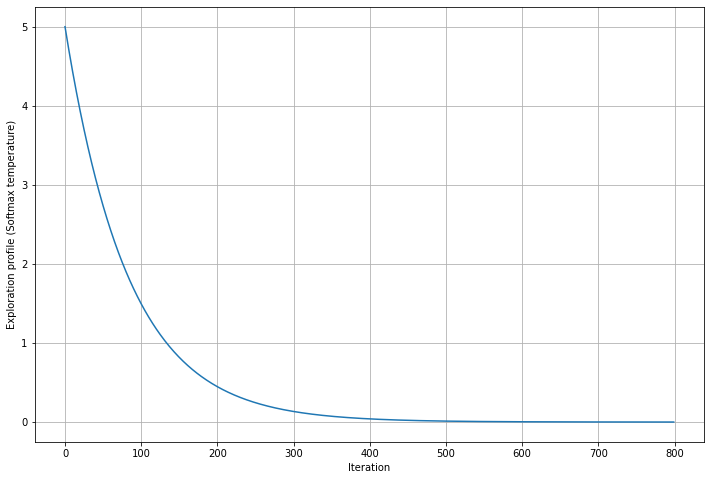

In [18]:
### Define exploration profile
initial_value = 5
num_iterations = 800
exp_decay = np.exp(-np.log(initial_value) / num_iterations * 6) # We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
exploration_profile = [initial_value * (exp_decay ** i) for i in range(num_iterations)]

### Plot exploration profile
plt.figure(figsize=(12,8))
plt.plot(exploration_profile)
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Exploration profile (Softmax temperature)')

In [19]:
### Create environment
env = gym.make('Acrobot-v1') # Initialize the Gym environment
env.seed(0) # Set a random seed for the environment (reproducible results)

# Get the shapes of the state space (observation_space) and action space (action_space)
state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"STATE SPACE SIZE: {state_space_dim}")
print(f"ACTION SPACE SIZE: {action_space_dim}")

STATE SPACE SIZE: 6
ACTION SPACE SIZE: 3


In [ ]:
# Set random seeds
torch.manual_seed(0)
np.random.seed(0)

### PARAMETERS
gamma = 0.99   # gamma parameter for the long term reward
replay_memory_capacity = 10000   # Replay memory capacity

lr = 1e-3
target_net_update_steps = 10   # Number of episodes to wait before updating the target network
batch_size = 256   # Number of samples to take from the replay memory for each update
bad_state_penalty = 0   # Penalty to the reward when we are in a bad state
min_samples_for_training = 1000   # Minimum samples in the replay memory to enable the training

In [ ]:
### Initialize the replay memory
replay_mem = ReplayMemory(replay_memory_capacity)    

### Initialize the policy network
policy_net = DQN(state_space_dim, action_space_dim).to(device)

### Initialize the target network with the same weights of the policy network
target_net = DQN(state_space_dim, action_space_dim).to(device)
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

### Initialize the optimizer
optimizer = torch.optim.Adam(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network

### Initialize the loss function (Huber loss)
loss_fn = nn.SmoothL1Loss()

In [20]:
def update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size):
        
    # Sample the data from the replay memory
    batch = replay_mem.sample(batch_size)
    batch_size = len(batch)

    # Create tensors for each element of the batch
    states      = torch.tensor([s[0] for s in batch], dtype=torch.float32, device=device)
    actions     = torch.tensor([s[1] for s in batch], dtype=torch.int64, device=device)
    rewards     = torch.tensor([s[3] for s in batch], dtype=torch.float32, device=device)

    # Compute a mask of non-final states (all the elements where the next state is not None)
    non_final_next_states = torch.tensor([s[2] for s in batch if s[2] is not None], dtype=torch.float32, device=device) # the next state can be None if the game has ended
    non_final_mask = torch.tensor([s[2] is not None for s in batch], dtype=torch.bool)

    # Compute all the Q values (forward pass)
    policy_net.train()
    q_values = policy_net(states)
    # Select the proper Q value for the corresponding action taken Q(s_t, a)
    state_action_values = q_values.gather(1, actions.unsqueeze(1).cuda())

    # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
    with torch.no_grad():
      target_net.eval()
      q_values_target = target_net(non_final_next_states)
    next_state_max_q_values = torch.zeros(batch_size, device=device)
    next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0].detach()

    # Compute the expected Q values
    expected_state_action_values = rewards + (next_state_max_q_values * gamma)
    expected_state_action_values = expected_state_action_values.unsqueeze(1)# Set the required tensor shape

    # Compute the Huber loss
    loss = loss_fn(state_action_values, expected_state_action_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # Apply gradient clipping (clip all the gradients greater than 2 for training stability)
    nn.utils.clip_grad_norm_(policy_net.parameters(), 2)
    optimizer.step()

In [ ]:
# Initialize the Gym environment
env = gym.make('Acrobot-v1') 
env.seed(0) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: episode_id % 100 == 0) # Save a video every 100 episodes

plotting_rewards=[]

for episode_num, tau in enumerate(tqdm(exploration_profile)):

    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False

    # Go on until the pole falls off
    while not done:

      # Choose the action following the policy
      action, q_values = choose_action_softmax(policy_net, state, temperature=tau)
      
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)

      # Update the final score (+1 for each step)
      score += reward

      # Apply penalty for bad state
      if done:
          reward += bad_state_penalty
          next_state = None
      
      # Update the replay memory
      replay_mem.push(state, action, next_state, reward)

      # Update the network
      if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
          update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)

      # Visually render the environment (disable to speed up the training)
      env.render()

      # Set the current state for the next iteration
      state = next_state

    # Update the target network every target_net_update_steps episodes
    if episode_num % target_net_update_steps == 0:
        print('Updating target network...')
        target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network
    
    plotting_rewards.append(score)
    # Print the final score
    print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score

env.close()

  0%|          | 0/800 [00:00<?, ?it/s]

Updating target network...
EPISODE: 1 - FINAL SCORE: -500.0 - Temperature: 5.0
EPISODE: 2 - FINAL SCORE: -500.0 - Temperature: 4.940008876649582


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  


EPISODE: 3 - FINAL SCORE: -500.0 - Temperature: 4.880737540275333
EPISODE: 4 - FINAL SCORE: -500.0 - Temperature: 4.822177354711398
EPISODE: 5 - FINAL SCORE: -500.0 - Temperature: 4.764319787410582
EPISODE: 6 - FINAL SCORE: -500.0 - Temperature: 4.707156408201104
EPISODE: 7 - FINAL SCORE: -500.0 - Temperature: 4.650678888058284
EPISODE: 8 - FINAL SCORE: -500.0 - Temperature: 4.594878997890946
EPISODE: 9 - FINAL SCORE: -500.0 - Temperature: 4.539748607342402
EPISODE: 10 - FINAL SCORE: -500.0 - Temperature: 4.485279683605809
Updating target network...
EPISODE: 11 - FINAL SCORE: -500.0 - Temperature: 4.431464290253745
EPISODE: 12 - FINAL SCORE: -500.0 - Temperature: 4.378294586081827
EPISODE: 13 - FINAL SCORE: -500.0 - Temperature: 4.325762823966207
EPISODE: 14 - FINAL SCORE: -500.0 - Temperature: 4.273861349734766
EPISODE: 15 - FINAL SCORE: -500.0 - Temperature: 4.222582601051861
EPISODE: 16 - FINAL SCORE: -500.0 - Temperature: 4.171919106316454
EPISODE: 17 - FINAL SCORE: -500.0 - Temper

In [ ]:
show_videos()


SHOWING VIDEO video/openaigym.video.1.74.video000000.mp4



SHOWING VIDEO video/openaigym.video.1.74.video000100.mp4



SHOWING VIDEO video/openaigym.video.1.74.video000200.mp4



SHOWING VIDEO video/openaigym.video.1.74.video000300.mp4



SHOWING VIDEO video/openaigym.video.1.74.video000400.mp4



SHOWING VIDEO video/openaigym.video.1.74.video000500.mp4



SHOWING VIDEO video/openaigym.video.1.74.video000600.mp4



SHOWING VIDEO video/openaigym.video.1.74.video000700.mp4


No handles with labels found to put in legend.


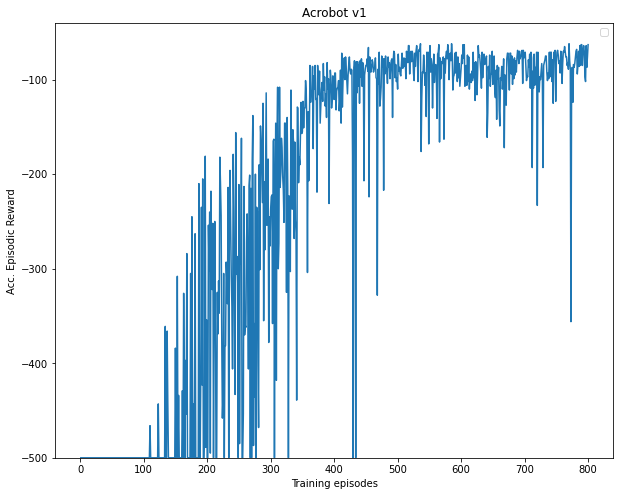

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(range(1,801),plotting_rewards)
plt.xlabel('Training episodes')
plt.ylabel('Acc. Episodic Reward')
plt.ylim([-500,-40])
#plt.grid()
plt.legend()
plt.title('Acrobot v1')
plt.show()

In [ ]:
# Initialize the Gym environment
env = gym.make('Acrobot-v1') 
env.seed(0) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: True) # Save a video every episode

plotting_rewards2=[]
# Let's try for a total of 10 episodes
for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the lower leg bents up
    score = 0
    done = False
    # Go on until the pole falls off or the score 360
    while not done:
      # Choose the best action (temperature 0)
      action, q_values = choose_action_softmax(policy_net, state, temperature=0)
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment
      env.render()
      # Update the final score (+1 for each step)
      score += reward 
      # Set the current state for the next iteration
      state = next_state
      # Check if the episode ended
    # Print the final score
    plotting_rewards2.append(score)
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 
env.close()

In [ ]:
show_videos()

### Anew Traininig

# Hyperparams

In [21]:
def initialize(params, replay_memory_capacity=10000, state_space_dim=state_space_dim, action_space_dim=action_space_dim):
    ### Initialize the replay memory
    replay_mem = ReplayMemory(replay_memory_capacity)    

    ### Initialize the policy network
    policy_net = DQN(state_space_dim, action_space_dim)

    ### Initialize the target network with the same weights of the policy network
    target_net = DQN(state_space_dim, action_space_dim)
    # Copy the weights of the policy network to the target network
    target_net.load_state_dict(policy_net.state_dict()) 
    
    ### Initialize the optimizer
    # The optimizer will update ONLY the parameters of the policy network
    optimizer = torch.optim.SGD(policy_net.parameters(), lr=params['learning_rate']) 
    
    ### Initialize the loss function (Huber loss)
    loss_fn = nn.SmoothL1Loss()
    
    return replay_mem, policy_net, target_net, optimizer, loss_fn

In [ ]:
seed = 0

def rnd_seed(seed=0):
    torch.manual_seed(seed)    
    np.random.seed(seed)
    random.seed(seed)

def avg_window(values, window):
    weights = np.repeat(1.0, window)/window
    running_avg = np.convolve(values, weights, 'valid')
    return running_avg

In [ ]:
def choose_action_softmax(net, state, temperature):
    
    if temperature < 0:
        raise Exception('The temperature value must be greater than or equal to 0 ')
        
    # If the temperature is 0, just select the best action using the eps-greedy policy with epsilon = 0
    if temperature == 0:
        return choose_action_epsilon_greedy(net, state, 0)
    
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32)
        net_out = net(state)

    # Apply softmax with temp
    temperature = max(temperature, 1e-8) # set a minimum to the temperature for numerical stability
    softmax_out = nn.functional.softmax(net_out / temperature, dim=0).numpy()
                
    # Sample the action using softmax output as mass pdf
    all_possible_actions = np.arange(0, softmax_out.shape[-1])
    action = np.random.choice(all_possible_actions, p=softmax_out) # this samples a random element from "all_possible_actions" with the probability distribution p (softmax_out in this case)
    
    return action, net_out.numpy()

In [ ]:
### Define exploration profile
def expl_profile_softmax(num_iterations=400, initial_value=5):
    # We compute the exponential decay in such a way the shape of the 
    # exploration profile does not depend on the number of iterations
    if initial_value == 1:
        exploration_profile = np.array([np.exp(-i / num_iterations * 6 ) for i in range(num_iterations)])
    else:    
        exp_decay = np.exp(-np.log(initial_value) / num_iterations * 6) 
        exploration_profile = np.array([initial_value * (exp_decay ** i) for i in range(num_iterations)])

    return exploration_profile

def expl_profile_linear(num_iterations=400, initial_value=5, end_value=0, reach_end=400):
    # linear decay for the first @reach_end epochs, then profile is =@end_value
    decay = np.array([initial_value - (initial_value-end_value)/ reach_end *  i for i in range(reach_end)])
    const = np.ones(num_iterations - reach_end) * end_value
    
    exploration_profile = np.hstack((decay, const))
    
    return exploration_profile

def gauss_fluctuation(x, mu = 0., sigma = 1., A = 1.):
    # simple gaussian function for adding gaussian fluctuation to the exploration profile
    return A * np.exp(-0.5 * (x - mu)**2/sigma**2) / (sigma * np.sqrt(2*np.pi))

In [ ]:
def expl_profile_softmax_cnn(num_iterations=400, initial_value=1., reach_end=400):
    # We compute the exponential decay in such a way the shape of the 
    # exploration profile does not depend on the number of iterations
    if initial_value == 1:
        exp_decay = np.array([np.exp(-i / num_iterations * 6 ) for i in range(reach_end)])
        const = np.ones(num_iterations - reach_end) * exp_decay[-1]
        exploration_profile = np.hstack((exp_decay, const))
    else:    
        exp_decay = np.exp(-np.log(initial_value) / num_iterations * 6) 
        exploration_profile = np.array([initial_value * (exp_decay ** i) for i in range(num_iterations)])
    
    return exploration_profile

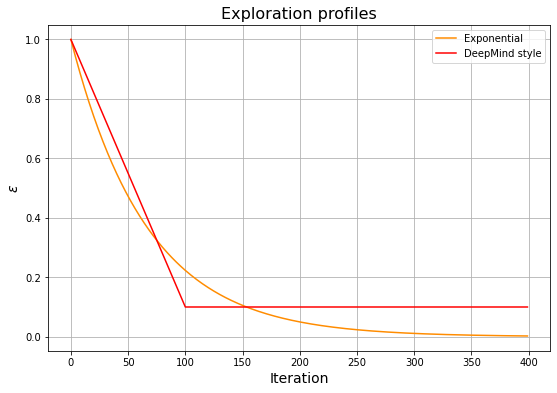

In [ ]:
# cnn_expl_prof = expl_profile_softmax(num_iterations=200, initial_value=5)
# cnn_expl_prof = expl_profile_softmax_cnn()#(num_iterations=500, initial_value=1)
cnn_expl_prof = expl_profile_softmax_cnn(num_iterations=400, initial_value=1., reach_end=400)
lin_expl_prof = expl_profile_linear(num_iterations=400, initial_value=1., end_value=0.1, reach_end=100)

fig, ax = plt.subplots(figsize=(9,6))
col = 'darkorange'

plt.plot(cnn_expl_prof, c=col, label='Exponential')
plt.grid()
plt.title('Exploration profiles', fontsize=16)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('$\\epsilon$', fontsize=14)

plt.plot(lin_expl_prof, c='red', label='DeepMind style')
plt.legend(loc='best')
plt.show()

In [ ]:
### Define exploration profile
def expl_profile_softmax(num_iterations=400, initial_value=5):
    # We compute the exponential decay in such a way the shape of the 
    # exploration profile does not depend on the number of iterations
    if initial_value == 1:
        exploration_profile = np.array([np.exp(-i / num_iterations * 6 ) for i in range(num_iterations)])
    else:    
        exp_decay = np.exp(-np.log(initial_value) / num_iterations * 6) 
        exploration_profile = np.array([initial_value * (exp_decay ** i) for i in range(num_iterations)])

    return exploration_profile

def expl_profile_linear(num_iterations=400, initial_value=5, end_value=0, reach_end=400):
    # linear decay for the first @reach_end epochs, then profile is =@end_value
    decay = np.array([initial_value - (initial_value-end_value)/ reach_end *  i for i in range(reach_end)])
    const = np.ones(num_iterations - reach_end) * end_value
    
    exploration_profile = np.hstack((decay, const))
    
    return exploration_profile

def gauss_fluctuation(x, mu = 0., sigma = 1., A = 1.):
    # simple gaussian function for adding gaussian fluctuation to the exploration profile
    return A * np.exp(-0.5 * (x - mu)**2/sigma**2) / (sigma * np.sqrt(2*np.pi))

In [ ]:
def initialize(params, replay_memory_capacity=10000, state_space_dim=state_space_dim, action_space_dim=action_space_dim):
    ### Initialize the replay memory
    replay_mem = ReplayMemory(replay_memory_capacity)    

    ### Initialize the policy network
    policy_net = DQN(state_space_dim, action_space_dim)

    ### Initialize the target network with the same weights of the policy network
    target_net = DQN(state_space_dim, action_space_dim)
    # Copy the weights of the policy network to the target network
    target_net.load_state_dict(policy_net.state_dict()) 
    
    ### Initialize the optimizer
    # The optimizer will update ONLY the parameters of the policy network
    optimizer = torch.optim.SGD(policy_net.parameters(), lr=params['learning_rate']) 
    
    ### Initialize the loss function (Huber loss)
    loss_fn = nn.SmoothL1Loss()
    
    return replay_mem, policy_net, target_net, optimizer, loss_fn

In [ ]:
def train_loop(policy_net, target_net, replay_mem, exploration_profile, params, seed=0, verbose=False):
    '''
    Function that defines the main training process
    '''

    # Initialize the Gym environment
    env = gym.make('Acrobot-v1') 
    rnd_seed(seed) # Set a random seed for the environment (reproducible results)
    env.seed(seed)
    
    # initialise output list containing all the scores
    scores = []

    for episode_num, tau in enumerate(tqdm(exploration_profile)):

        # Reset the environment and get the initial state
        state = env.reset()
        # Reset the score. The final score will be the total amount of steps before the pole falls
        score = 0
        done = False

        # Go on until the pole falls off
        while not done:

            # Choose the action following the policy
            action, q_values = choose_action_softmax(policy_net, state, temperature=tau)

            # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
            next_state, reward, done, info = env.step(action)

            # IMPLEMENT FURTHER PENALTY HERE
            off_cen_penalty = 1.
            reward = reward - off_cen_penalty * np.abs(state[0])

            # Update the final score (+1 for each step)
            score += 1

            # Apply penalty for bad state
            if done: # if the pole has fallen down 
                reward += params['bad_state_penalty']
                next_state = None

            # Update the replay memory
            replay_mem.push(state, action, next_state, reward)

            # Update the network
            if len(replay_mem) > params['min_samples_for_training']: 
                # Enable the training only if there are enough samples in the replay memory
                # otherwise the training will use the same samples too often
                update_step(policy_net, target_net, replay_mem, optimizer, loss_fn, params)

            # Visually render the environment 
            # comment to speed up the training
            # env.render()

            # Set the current state for the next iteration
            state = next_state

        # Update the target network every target_net_update_steps episodes
        if episode_num % params['target_net_update_steps'] == 0:
            if verbose: print('Updating target network...')
            # Copy the weights of the policy network to the target network  
            target_net.load_state_dict(policy_net.state_dict()) 

        # Print the final score
        if verbose: 
            print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score
        # Save score
        scores.append(score)
    
    env.close()
    
    return policy_net, scores
    

In [ ]:
expl_profiles = []

type_prof = ['softmax', 'linear']

for i in range(15):
    
    if np.random.choice(type_prof) == 'linear':
        explos = expl_profile_linear(initial_value=np.random.randint(3, 7))
    else:
        explos = expl_profile_softmax(initial_value=np.random.randint(3, 7))
        
    num_it = len(explos)
    
    if np.random.rand() < 0.75:    
        j = np.random.randint(0, 9)
        g = gauss_fluctuation(np.linspace(-3, 3, 40))
        explos[j * (num_it//10): (j+1)*(num_it//10)] += g
        
        if np.random.rand() < 0.75:
            j = np.random.randint(0, 9)
            explos[j * (num_it//10): (j+1)*(num_it//10)] += gauss_fluctuation(np.linspace(-3, 3, 40))
    
    expl_profiles.append(explos)
    

In [ ]:
hyperparams = {'gamma': np.linspace(0.9, 0.99, 5),         # gamma parameter for the long term reward
               'replay_memory_capacity': [10000],          # Replay memory capacity
               'learning_rate': np.logspace(-3, -1, 10),   # Optimizer learning rate
               'target_net_update_steps': [10, 15, 20],    # Number of episodes to wait before updating the target network
               'batch_size': [64, 128, 256],               # Number of samples to take from the replay memory for each update
               'bad_state_penalty': [0],                   # Penalty to the reward when we are in a bad state
               'min_samples_for_training': [400]           # Minimum samples in the replay memory to enable the training
              }
def random_params(params):
    selected_params = {}
    for i in params.keys():
        selected_params[i] = np.random.choice( params[i] )
    return selected_params

print(random_params(hyperparams))

{'gamma': 0.9225, 'replay_memory_capacity': 10000, 'learning_rate': 0.03593813663804626, 'target_net_update_steps': 15, 'batch_size': 256, 'bad_state_penalty': 0, 'min_samples_for_training': 400}


In [ ]:
class ReplayMemory(object):

    def __init__(self, capacity):
        # Define a queue with maxlen "capacity"
        self.memory = deque(maxlen=capacity)

    def push(self, state, action, next_state, reward):
        # Add the tuple (state, action, next_state, reward) to the queue
        self.memory.append( (state, action, next_state, reward) )

    def sample(self, batch_size):
        batch_size = min(batch_size, len(self)) # Get all the samples 
        # if the requested batch_size is higher than the number of sample currently in the memory
        # Randomly select "batch_size" samples and return the selection
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory) # Return the number of samples currently stored in the memory

In [ ]:
action_space_dim

3

In [ ]:
state_space_dim

6

In [ ]:
net = DQN(state_space_dim, action_space_dim)
print(net)

DQN(
  (linear): Sequential(
    (0): Linear(in_features=6, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=3, bias=True)
  )
)


In [ ]:
## find the best model
rnd_seed() # reproducibility
env.seed(seed)

#outputs
all_params = []
all_train_scores = []
all_expl_profiles = []

for net in range(10):
    
    ### Set exploration profile
    exploration_profile = expl_profiles[ np.random.randint(0, len(expl_profiles))]
    
    ### PARAMETERS
    params = random_params(hyperparams)
    print('=====','Model', net,'=====')
    
    ### Initialization
    replay_mem, policy_net, target_net, optimizer, loss_fn = initialize(params)
    
    ### Training
    policy_net, training_score = train_loop(policy_net, target_net, replay_mem, exploration_profile, params)
    
    all_params.append(params)
    all_train_scores.append(training_score)
    all_expl_profiles.append(exploration_profile)

===== Model 0 =====


  0%|          | 0/400 [00:00<?, ?it/s]

===== Model 1 =====


  0%|          | 0/400 [00:00<?, ?it/s]

===== Model 2 =====


  0%|          | 0/400 [00:00<?, ?it/s]

===== Model 3 =====


  0%|          | 0/400 [00:00<?, ?it/s]

===== Model 4 =====


  0%|          | 0/400 [00:00<?, ?it/s]

===== Model 5 =====


  0%|          | 0/400 [00:00<?, ?it/s]

===== Model 6 =====


  0%|          | 0/400 [00:00<?, ?it/s]

===== Model 7 =====


  0%|          | 0/400 [00:00<?, ?it/s]

===== Model 8 =====


  0%|          | 0/400 [00:00<?, ?it/s]

===== Model 9 =====


  0%|          | 0/400 [00:00<?, ?it/s]

In [ ]:
# Select models which arrives to the desired score faster
for net, score in enumerate(np.array(all_train_scores)):
    
    mask = np.array(score) >= -80
    
    if score[mask].shape == (0,):
        all_params[net]['bestz'] = 1000
    else:    
        all_params[net]['bestz'] = np.where(mask)[0][0]

# type conversion
for net in all_params:
    for k in net.keys():
        if type(net[k])==np.int32 or type(net[k])==np.int64:
            net[k] = int( net[k] )
        elif type(net[k])==np.float32 or type(net[k])==np.float64:
            net[k] = float( net[k] )
                        

In [ ]:
hip.Experiment.from_iterable(all_params).display()

<IPython.core.display.Javascript object>

In [ ]:
plot_param = all_params
bestz = np.zeros(len(all_params))
for i, p in enumerate(plot_param):
    p.pop('replay_memory_capacity')
    p.pop('min_samples_for_training')
    p.pop('bad_state_penalty')
    bestz[i] = p['bestz']

fig = px.parallel_coordinates(plot_param, color='bestz', color_continuous_scale=px.colors.sequential.RdBu)
fig.show()

In [ ]:
best_param = all_params[np.argmin(bestz)]
best_param['replay_memory_capacity'] = 10000
best_param['min_samples_for_training'] = 1000
best_param['bad_state_penalty'] =0

print(best_param)

{'gamma': 0.9675, 'learning_rate': 0.05994842503189409, 'target_net_update_steps': 15, 'batch_size': 128, 'bestz': 0, 'replay_memory_capacity': 10000, 'min_samples_for_training': 1000, 'bad_state_penalty': 0}


In [ ]:
### best params
gamma = 0.9675   # gamma parameter for the long term reward
replay_memory_capacity = 10000   # Replay memory capacity
#lr = 1e-2   # Optimizer learning rate
#lr = 1e-4
lr = 0.05994842503189409
target_net_update_steps = 15   # Number of episodes to wait before updating the target network
batch_size = 128   # Number of samples to take from the replay memory for each update
bad_state_penalty = 0   # Penalty to the reward when we are in a bad state
min_samples_for_training = 1000   # Minimum samples in the replay memory to enable the training
best_param = {'gamma': [0.9675],
               'replay_memory_capacity': [10000],
               'learning_rate': 0.05994842503189409,
               'target_net_update_steps': [15],
               'batch_size': [128],
               'bad_state_penalty': [0],
               'min_samples_for_training': 1000
              }

In [ ]:
best_param 

{'gamma': [0.9675],
 'replay_memory_capacity': [10000],
 'learning_rate': 0.05994842503189409,
 'target_net_update_steps': [15],
 'batch_size': [128],
 'bad_state_penalty': [0],
 'min_samples_for_training': 1000}

In [22]:
### Initialize the replay memory
replay_mem = ReplayMemory(replay_memory_capacity)    

### Initialize the policy network
policy_net = DQN(state_space_dim, action_space_dim).to(device)

### Initialize the target network with the same weights of the policy network
target_net = DQN(state_space_dim, action_space_dim).to(device)
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

### Initialize the optimizer
optimizer = torch.optim.Adam(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network

### Initialize the loss function (Huber loss)
loss_fn = nn.SmoothL1Loss()

In [23]:
# Initialize the Gym environment
env = gym.make('Acrobot-v1') 
env.seed(0) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: episode_id % 100 == 0) # Save a video every 100 episodes

plotting_rewards=[]

for episode_num, tau in enumerate(tqdm(exploration_profile)):

    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False

    # Go on until the pole falls off
    while not done:

      # Choose the action following the policy
      action, q_values = choose_action_softmax(policy_net, state, temperature=tau)
      
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)

      # Update the final score (+1 for each step)
      score += reward

      # Apply penalty for bad state
      if done: # if the pole has fallen down 
          reward += bad_state_penalty
          next_state = None
      
      # Update the replay memory
      replay_mem.push(state, action, next_state, reward)

      # Update the network
      if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
          update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)

      # Visually render the environment (disable to speed up the training)
      env.render()

      # Set the current state for the next iteration
      state = next_state

    # Update the target network every target_net_update_steps episodes
    if episode_num % target_net_update_steps == 0:
        print('Updating target network...')
        target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network
    
    plotting_rewards.append(score)
    # Print the final score
    print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score

env.close()

  0%|          | 0/800 [00:00<?, ?it/s]

Updating target network...
EPISODE: 1 - FINAL SCORE: -500.0 - Temperature: 5.0
EPISODE: 2 - FINAL SCORE: -500.0 - Temperature: 4.940008876649582


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  


EPISODE: 3 - FINAL SCORE: -500.0 - Temperature: 4.880737540275333
EPISODE: 4 - FINAL SCORE: -500.0 - Temperature: 4.822177354711398
EPISODE: 5 - FINAL SCORE: -500.0 - Temperature: 4.764319787410582
EPISODE: 6 - FINAL SCORE: -500.0 - Temperature: 4.707156408201104
EPISODE: 7 - FINAL SCORE: -500.0 - Temperature: 4.650678888058284
EPISODE: 8 - FINAL SCORE: -500.0 - Temperature: 4.594878997890946
EPISODE: 9 - FINAL SCORE: -500.0 - Temperature: 4.539748607342402
EPISODE: 10 - FINAL SCORE: -500.0 - Temperature: 4.485279683605809
EPISODE: 11 - FINAL SCORE: -500.0 - Temperature: 4.431464290253745
EPISODE: 12 - FINAL SCORE: -500.0 - Temperature: 4.378294586081827
EPISODE: 13 - FINAL SCORE: -500.0 - Temperature: 4.325762823966207
EPISODE: 14 - FINAL SCORE: -500.0 - Temperature: 4.273861349734766
EPISODE: 15 - FINAL SCORE: -500.0 - Temperature: 4.222582601051861
Updating target network...
EPISODE: 16 - FINAL SCORE: -500.0 - Temperature: 4.171919106316454
EPISODE: 17 - FINAL SCORE: -459.0 - Temper

In [26]:
# Initialize the Gym environment
env = gym.make('Acrobot-v1') 
env.seed(0) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: True) # Save a video every episode

plotting_rewards2=[]
# Let's try for a total of 10 episodes
for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done:
      # Choose the best action (temperature 0)
      action, q_values = choose_action_softmax(policy_net, state, temperature=0)
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment
      env.render()
      # Update the final score (+1 for each step)
      score += reward 
      # Set the current state for the next iteration
      state = next_state
      # Check if the episode ended (the pole fell down)
    # Print the final score
    plotting_rewards2.append(score)
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 
env.close()

EPISODE 1 - FINAL SCORE: -500.0
EPISODE 2 - FINAL SCORE: -500.0
EPISODE 3 - FINAL SCORE: -500.0
EPISODE 4 - FINAL SCORE: -500.0
EPISODE 5 - FINAL SCORE: -500.0
EPISODE 6 - FINAL SCORE: -500.0
EPISODE 7 - FINAL SCORE: -500.0
EPISODE 8 - FINAL SCORE: -500.0
EPISODE 9 - FINAL SCORE: -500.0
EPISODE 10 - FINAL SCORE: -500.0


In [ ]:
# Initialize the Gym environment
env = gym.make('Acrobot-v1') 
env.seed(1) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: True) # Save a video every episode

plotting_rewards2=[]
# Let's try for a total of 10 episodes
for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done:
      # Choose the best action (temperature 0)
      action, q_values = choose_action_softmax(policy_net, state, temperature=0)
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment
      env.render()
      # Update the final score (+1 for each step)
      score += reward 
      # Set the current state for the next iteration
      state = next_state
      # Check if the episode ended (the pole fell down)
    # Print the final score
    plotting_rewards2.append(score)
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 
env.close()

EPISODE 1 - FINAL SCORE: -87.0
EPISODE 2 - FINAL SCORE: -84.0
EPISODE 3 - FINAL SCORE: -64.0
EPISODE 4 - FINAL SCORE: -90.0
EPISODE 5 - FINAL SCORE: -64.0
EPISODE 6 - FINAL SCORE: -94.0
EPISODE 7 - FINAL SCORE: -74.0
EPISODE 8 - FINAL SCORE: -71.0
EPISODE 9 - FINAL SCORE: -89.0
EPISODE 10 - FINAL SCORE: -94.0


In [24]:
# Initialize the Gym environment
env = gym.make('Acrobot-v1') 
env.seed(0) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: True) # Save a video every episode

plotting_rewards2=[]
# Let's try for a total of 10 episodes
for num_episode in range(20): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    while not done:
      # Choose the best action (temperature 0)
      action, q_values = choose_action_softmax(policy_net, state, temperature=0)
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment
      env.render()
      # Update the final score (+1 for each step)
      score += reward 
      # Set the current state for the next iteration
      state = next_state
      # Check if the episode ended (the pole fell down)
    # Print the final score
    plotting_rewards2.append(score)
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 
env.close()

EPISODE 1 - FINAL SCORE: -500.0
EPISODE 2 - FINAL SCORE: -500.0
EPISODE 3 - FINAL SCORE: -500.0
EPISODE 4 - FINAL SCORE: -500.0
EPISODE 5 - FINAL SCORE: -500.0
EPISODE 6 - FINAL SCORE: -500.0
EPISODE 7 - FINAL SCORE: -500.0
EPISODE 8 - FINAL SCORE: -500.0
EPISODE 9 - FINAL SCORE: -500.0
EPISODE 10 - FINAL SCORE: -500.0
EPISODE 11 - FINAL SCORE: -500.0
EPISODE 12 - FINAL SCORE: -500.0
EPISODE 13 - FINAL SCORE: -500.0
EPISODE 14 - FINAL SCORE: -500.0
EPISODE 15 - FINAL SCORE: -500.0
EPISODE 16 - FINAL SCORE: -500.0
EPISODE 17 - FINAL SCORE: -500.0
EPISODE 18 - FINAL SCORE: -500.0
EPISODE 19 - FINAL SCORE: -500.0
EPISODE 20 - FINAL SCORE: -500.0


In [ ]:
show_videos()